# Exercise 1.2.2: Image Manipulation and Masking
#### By Jonathan L. Moran (jonathan.moran107@gmail.com)
From the Self-Driving Car Engineer Nanodegree programme offered at Udacity.

## Objectives
* Get familiar with colour thresholding;
* Create and display [binary masks](https://en.wikipedia.org/wiki/Mask_\(computing\)) from RGB images;
* Use binary masks to clip pixel values;
* Calculate per-channel statistics ([mean](https://en.wikipedia.org/wiki/Arithmetic_mean) and [standard deviation](https://en.wikipedia.org/wiki/Standard_deviation));
* Generate per-channel [histograms](https://en.wikipedia.org/wiki/Color_histogram) of pixel value distributions.

## 1. Introduction

In [1]:
### Importing required modules

In [2]:
from collections import defaultdict, namedtuple
from copy import copy
import cv2
import glob
import logging
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import os
from PIL import Image, ImageStat
import seaborn as sns
from typing import List
from typing import NamedTuple

In [3]:
### Settng environment variables

In [4]:
ENV_COLAB = False                # True if running in Google Colab instance

In [5]:
DIR_BASE = '' if not ENV_COLAB else '/content/'
DIR_OUT = os.path.join(DIR_BASE, 'out/')

### 1.1. Colour Thresholding

_What is colour thresholding?_

In plain language, colour thresholding is the process of isolating and preserving a specific colour (or range/bin of colours) in a digital image and discarding the rest. 

_Why might we use it in self-driving cars?_

Colour thresholding can be a useful, albeit rudimentary starting point for handling the various perception tasks of an Advanced Driver Assistance System (ADAS). These tasks might include: lane line detection, street sign text extraction, and vehicle headlight segmentation, to name a few. Colour thresholding might also be a useful alternative to grayscale image conversion, which throws out _all_ colour information from an image.

##### Terminology

* **Colour model**: abstract representation of colours as tuples of numbers;
* **Hue**: describes the dimension of a colour we see;
* **Value**: describes how 'bright' or 'dark' that colour is;
* **Saturation**: describes the intensity and brilliance of that colour.

##### A note on colour models

One cannot talk about colour thresholding without first discussing a bit about colour and the way it is represented in the digital and physical world. _Colour models_ are the "languages" used to represent the millions of colours that exist in a format that is easily digestible by machines. Using a combination of values — often a set of three or four numbers, colour models can identify tens of millions of colours. These values, e.g., `(0, 0, 0)` in the [RGB](https://en.wikipedia.org/wiki/RGB_color_model) colour model map to the colour 'black'. Each "color language" has a different way of mapping colours and these languages can vary from device to device (a printer, for example, uses the [CMYK](https://en.wikipedia.org/wiki/CMYK_color_model) colour model, while a computer monitor uses RGB). These differences lend themselves to the devices that are processing and displaying these colours and to the mediums the colours will be displayed on.

Many factors go into choosing a colour model, but for our purposes in this exercise, we will be covering the RGB and [HSL/HSV](https://en.wikipedia.org/wiki/HSL_and_HSV) colour models for both their practicality in digital imaging and for their specific colour-making attributes that we will exploit in our work.

###### RGB colour model

[RGB](https://en.wikipedia.org/wiki/RGB_color_model) is an additive colour model with three _channels_: red, green and blue. The three channels are superimposed to create a composite colour image.

In digital RGB images, each [channel](https://en.wikipedia.org/wiki/Channel_\(digital_image\)) is in of itself a monochromatic (grayscale) image composed of 8-bit pixel intensity values. Each pixel value is a number in the range [0, 255], or [0,1] if normalised, determining the brightness of a colour at a given location. The higher the value, the 'brighter' or more intense that colour is. The combinations of these brightness intensity values across the three channels results in a unique mapping to one of $256*256*256 \simeq 16.77 \ \mathrm{million} $ possible colours.

RGB is an _additive_ colour model; mixing all three channels red, green and blue results in the colour white, and it is considered to be counter-intuitive to the way humans naturally perceive colours in their physical form. Dyes and paints, in contrast, are _subtractive colour_ mediums and create the colour 'black' when mixed.

RGB may be a very popular colour model used in many electronics from computer monitors to digital cameras, but this model does come with a few notable downsides. While RGB values do not need to be transformed in order to be understood across devices, the colours resulting from the RGB values may appear different from device to device. To match colour replication across devices, a [colour management](https://en.wikipedia.org/wiki/Color_management) software is used. Another downside to the RGB model is that the difference between colour values is not linear, meaning that we can't simply 'double' the RGB values of a colour to get twice its perceived intensity.

###### HSL and HSV colour models

[HSL and HSV](https://en.wikipedia.org/wiki/HSL_and_HSV), (_Hue, Saturation, Lightness_ and _Hue, Saturation, Value_, respectively) are two alternative representations to the additive RGB colour model. The motivation behind these two models differs, as HSL was invented to introduce colour encoding via a _chrominance_ channel to an existing monochromatic (_luminance_-only) television broadcasting format. HSV, on the other hand, was invented to create a model that better replicated how humans perceive colour, i.e., in terms of hue, lightness and chroma; as well how colours were traditionally mixed in physical space, e.g., in painting. Since humans tend to first describe a colour based on its hue, then its characteristics such as brightness, saturation, brilliance, etc., the HSV model attempts to represent colours with this logic by binning them into hues, then further describing their appearance using parameters that humans are more familiar with, e.g., [tint, shade and tone](https://en.wikipedia.org/wiki/Tint,_shade_and_tone) [1] (Joblove et al., 1978).

In our work we will be converting RGB images to HSV so that we can query a specific hue (e.g., 'yellow') and more easily bin it into a range of colour values that suit our needs (e.g., "get me the values similar to this 'yellow' lane line").

##### Our task

Below in Fig. 1. we see a set of three images. Upon closer inspection we see that these images are the same frame i.e., image, within a driving scene.

![Fig. 1. Example output figure given by Udacity.](figures/2022-08-17-Figure-1-Example-Output.png)

$$
\begin{align}
    \textrm{Fig. 1. Example output of a colour thresholded image (Credit: Udacity).}
    \end{align}
$$

_What's different about them?_

On the _left_ we have the original colour image before any processing. The _middle_ image is the _binary mask_ generated from thresholding a certain range of RGB colour values in the original image. The resulting yellow colour in the mask is assigned a binary value of '1' and represents all pixels from the original image to preserve. The  purple colour in the middle image corresponds to all pixels from the original image to discard and has a binary value of '0'. The third image shown on the _right_ is the final output image. In this image, pixel values in black have been clipped (removed) in locations where the binary mask value was 'purple' i.e., binary value '0'.

Our goal in this Exercise is to take input images like the one on the left and produce binary masks (middle) and clipped images (right) by implementing a technique called colour thresholding, i.e., removing all colours above, equal to, or below a given colour.

#### Background

In order to select a colour to threshold — for example, 'yellow' — we first have to understand _how_ that colour will be represented in an image and in _what conditions_ that colour will be displayed. Let's start with the image in Fig. 2 below.

![Fig. 2. Identifying a colour in RGB.](figures/2022-08-17-Figure-2-Colour-Picker.jpg)

$$
\begin{align}
    \textrm{Fig. 2. Identifying a colour using the Generic RGB model with macOS Digital Colour Meter (Image credit: } \href{https://unsplash.com/photos/5FHv5nS7yGg}{Unsplash}\textrm{).}
    \end{align}
$$

We can start this task with a hypothetical scenario for our self-driving car in mind. That is; we want to know where in this image the lane divider, i.e., that [yellow line](https://en.wikipedia.org/wiki/Yellow_line_(road_marking)), is on the road surface. 

It's pretty easy for human drivers to identify where the centre-line is and segment it out based on its colour. Going even further, we can rapidly associate the yellow-coloured surface by applying _context_ (scene details) and even local driving rules. And since we're human drivers, we can continue to detect this lane line in a variety of tough scenarios — at nighttime, on extremely sunny days, in many types of weather conditions, etc.

For a machine vision system, as we will see soon, a task like this is not so easy.

However, let's start this journey by using the simple tools we have available to us. Applications like the MacOS [Digital Colour Meter](https://support.apple.com/en-gb/guide/digital-color-meter/welcome/mac) make it relatively painless to pinpoint at the pixel-level colours rendered on digital devices (in this case, we're using the RGB colour model to display this image on a computer monitor).

We can start by looking up the RGB pixel values of the yellow line in an application like MacOS Digital Colour Meter. From Fig. 2, we obtain the tuple `(R:209, G:144, B:17)` for a specific pixel in the yellow region. Great! Now we should be able to eliminate all other colours in the image and get our center lane mask, right?

Not so fast. We'll see what happens when we try masking an image using only a single RGB colour value in Sect. 2.1.

### 1.2. Binary Masks

#### Background

A binary [mask](https://en.wikipedia.org/wiki/Mask_\(computing\)) in computing is a set of bits that define which binary values (1s and 0s) to preserve when performing a bitwise operation on binary data. _Masking_ is the act of applying a binary mask to an input value to keep, change or remove a desired part of that value.

For example, the binary mask
```
mask = b1101
```
when applied to the following input bitstring
```
input = b1111
```
using a bitwise _AND_ operation, we obtain
```
mask  = b1100
input = b0111
-------------
AND   = b0100
      
```
In other words, applying the mask to the input image eliminated (or "masked") the two right-most `1` bits to 'off' (`0`).

Binary masks are used in many areas of computer science. In this Exercise, we will see how binary masks can help us eliminate certain regions within an image. Regions of interest within an image can be defined by many attributes, but we will be using colour values to mask ("clip") that we do not want in our desired output.

#### Binary masks for image thresholding

In this step we will be taking the colour range values we calculated previously to threshold, i.e., isolate, regions with these pixel values in an image. The intermediary in this step is a mask of equal dimensions to the input image but with binary values `0`, `1` instead of pixel colour values. These binary values indicate the presence of pixels in the given range, i.e., `mask == 1`. If any pixel values are outside of the calculated range, they are assigned a value of `0`.

### 1.3. Image Masking

#### Background

From the above we learned that binary masks are used to 'clip' or remove certain features in an image using a bitwise _AND_ operation. In computer graphics, these binary masks are often referred to as _bitmaps_ since they map image pixels to a domain of binary digits. The bitmappings describe which pixels to preserve and which to discard. In this section you will learn how binary masks are _applied_ to images composed of pixel values to result in a image with a region of interest left intact.

#### Image masking with OpenCV

The OpenCV `bitwise_and()` method calculates a per-element bit-wise conjunction of two input arrays. For each pixel value pair the logical _and_ operator is performed, such that each pixel $a_{[i,j]}$ from the original image will be multiplied by its corresponding pair in the binary mask $b_{[i,j]}$. 

Where mask values are equal to zero, i.e., $b_{[i,j]} = 0$, we have:
* `a_[i,j] AND 0 == a_[i,j] * 0.0 = 0`,

and where mask values are equal to one, i.e., $b_{[i,j]} = 1$, we have:
* `a_[i,j] AND 1 == a_[i,j] * 1.0 = a_[i,j]`.

### 1.4. Pixel Value Statistics

#### Background

* Calculating the channel-wise mean and standard deviation of a list of images;
* Display pixel value distributions per channel.

In this section we will be computing and visualising pixel value statistics from our set of images. One such application of this in self-driving cars is a _histogram of color features_. As the name implies, a histogram is computed from a distribution of colour features (i.e., the R, G, B colour channel values) and used as a rudimentary technique for object segmentation. 

[Colour histograms](https://en.wikipedia.org/wiki/Color_histogram) are scale-, shift- and rotation-invariant, but they suffer from several notable problems when used for object detection. The first is that they are sensitive to noise — any change in brightness/intensity will result in a change in the distribution of colour values. However, using appropriate colour models like HSV/HSL might help address some of this sensitivity. Another major flaw with the colour histogram approach is that they struggle to properly _identify_ objects. That is, an image of a red-and-white car might be indistinguishable from an image of a red-and-white stop sign as their colour distributions might be very similar. Colour histograms therefore have no concept of an object's shape or texture and disregard any spatial information (i.e., where in the image an object was located). 

Despite these drawbacks, histogram of colour features are often used as image descriptors in information retrieval tasks for their computational efficiency and ease of implementation.

#### Computing mean and standard deviation

Mean and standard deviation can be computed in two modes: _RGB average_ and _luminosity_. RGB average is simply the mean value of the per-channel averages, i.e., the RGB colour component averages without any transformations

$$ \mu_{c_{i}} = \frac{1}{n} \sum_{j=1}^{n} x_{i,j}.$$

One other way to calculate a more visually-accurate mean average of an RGB image is to _square_ each RGB component (pixel value),

$$ \mu_{c_{i}} = \cdot \sqrt{ \frac{1}{n} \sum_{j=1}^{n} x_{i,j}^2}.$$

The reasoning behind this approach is explained wonderfully in [this](https://www.youtube.com/watch?v=LKnqECcg6Gw&t=225s) Minutephysics video. In short, squaring the pixel values helps account for the non-linearity of RGB brightness values. When taking the 'simple' local average of two contrasting colours (say, 'red' and 'green'), the result will likely be much darker than expected (in this case, a dark shade of 'brown'). By squaring the RGB components, we obtain a much more representative mean value.

![Fig. 3. Averaging RGB Values.](figures/2022-08-17-Figure-3-Averaging-RGB-Values.png)


$$
\begin{align}
    \textrm{Fig. 3. Averaging RGB values with and without squaring the components.}
    \end{align}
$$

## 2. Programming Task

### 2.1. Colour Thresholding

In this task we will be defining a range of values to threshold from a given colour. To get a range of values, we have to determine an acceptable upper and lower bound. 

Let's start by defining a simple percent change function that takes in a set of values and a percent between [0,1] to adjust them by. Here, the sign parameter indicates whether to _increase_ (`sign = 1.0`) or _decrease_ (`sign = -1.0`) the values by the respective percent.

In [6]:
def percent_change(xs, percent: float, sign: float=1.0) -> list:
    """Returns list of values modified by a decimal percentage."""
    return [x * (1 + percent * sign) for x in xs]

Now let's define a few custom `NamedTuple` subclasses for our RGB, BGR and HSV colour models.

In [7]:
### Creating subclasses for custom methods

In [8]:
class RGB(NamedTuple):
    """Three-channel colour model, each with 8-bit values in range [0,255]."""
    r: int = 255      # Red channel
    g: int = 255      # Green channel
    b: int = 255      # Blue channel
        
    def threshold(self, percent: float, sign: float=1.0) -> list:
        """Returns the modified RGB values."""
        assert percent <= 1.0
        r, g, b = map(int, percent_change(self, percent, sign))
        return [min(r, 255), min(g, 255), min(b, 255)]
        
    def convert_to_rgb(self) -> list:
        """Returns a list of RGB values."""
        return [self.r, self.g, self.b]
        
    def convert_to_bgr(self) -> list:
        """Converts RGB to BGR values"""
        bgr_colour = cv2.cvtColor(np.uint8([[self]]), cv2.COLOR_RGB2BGR)
        return bgr_colour.reshape(3,).tolist()
    
    def convert_to_hsv(self) -> list:
        """Converts RGB to HSV values."""
        hsv_colour = cv2.cvtColor(np.uint8([[self]]), cv2.COLOR_RGB2HSV)
        return hsv_colour.reshape(3,).tolist()

In [9]:
class BGR(NamedTuple):
    """Three-channel colour model, each with 8-bit values in range [0,255]."""
    b: int = 255      # Blue channel
    g: int = 255      # Green channel
    r: int = 255      # Red channel        
        
    def threshold(self, percent: float, sign: float=1.0) -> list:
        """Returns the modified BGR values."""
        assert percent <= 1.0
        b, g, r = map(int, percent_change(self, percent, sign))
        return [min(b, 255), min(g, 255), min(r, 255)]
        
    def convert_to_rgb(self) -> list:
        """Converts BGR to RGB values."""
        rgb_colour = cv2.cvtColor(np.uint8([[self]]), cv2.COLOR_BGR2RGB)
        return RGB(*rgb_colour.reshape(3,))
        return rgb_colour.reshape(3,)

    def convert_to_bgr(self) -> list:
        """Returns a list of BGR values."""
        return [self.b, self.g, self.r]
    
    def convert_to_hsv(self) -> list:
        """Converts BGR to HSV values."""
        hsv_colour = cv2.cvtColor(np.uint8([[self]]), cv2.COLOR_BGR2HSV)
        return hsv_colour.reshape(3,)

In [10]:
class HSV(NamedTuple):
    """Three-value colour model, each with 8-bit values."""
    h: int = 179      # Hue:        [0, 179] (one-half 360 deg for 8-bit)
    s: int = 255      # Saturation: [0, 255]
    v: int = 255      # Value:      [0, 255]        
        
    def threshold(self, percent: float, sign: float=1.0) -> list:
        """Returns the modified HSV values."""
        assert percent <= 1.0
        h, s, v = map(int, percent_change(self, percent, sign))
        return [min(h,179),min(s,255),min(v,255)]
    
    def convert_to_rgb(self) -> list:
        """Converts HSV to RGB values."""
        rgb_colour = cv2.cvtColor(np.uint8([[self]]), cv2.COLOR_HSV2RGB)
        return rgb_colour.reshape(3,).tolist()
        
    def convert_to_bgr(self) -> list:
        """Converts HSV to BGR values."""
        bgr_colour = cv2.cvtColor(np.uint8([[self]]), cv2.COLOR_HSV2BGR)
        return bgr_colour.reshape(3,).tolist()
    
    def convert_to_hsv(self) -> list:
        """Returns a list of HSV values."""
        return [self.h, self.s, self.v]

Note that HSV values have different scaling applied to them depending on the software being used to read and manipulate those values. With OpenCV `cv2` Python library, we will use HSV values with a modified hue channel ranging from `[0,179]` degrees (one-half the 360 degree range) such that we can fit the number to an 8-bit value. 

More information on colour models in OpenCV can be found [here](https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html).

In [11]:
### From J. Moran's `2022-08-10-Calibration-Distortion-Correction.ipynb`

In [12]:
def is_grayscale(img_path: str) -> bool:
    """Checks if grayscale image by channel count and value.
    Credit: https://stackoverflow.com/a/58791118
    """
    
    img = cv2.imread(img_path)
    if len(img.shape) < 3 or len(img.shape) == 1:
        return True
    # Check that channel values are not same
    b, g, r = img[:,:,0], img[:,:,1], img[:,:,2]
    if (b==g).all() and (b==r).all(): return True
    else: return False

#### Colour thresholding algorithm in Python

We will be testing our thresholding function first with the RGB colour we identified in Fig. 2.

In [13]:
### Defining the colour of interest
colour_original = RGB(209, 144, 17)
colour_original

RGB(r=209, g=144, b=17)

In [14]:
### Testing a 20% threshold amount
colour_original.threshold(percent=0.2, sign=1.0)

[250, 172, 20]

In [15]:
### Obtaining the threshold bounds

In [16]:
# Setting the threshold amount
threshold_percent = 0.20            # value between [0,1]
# Getting upper and lower bounds as RGB instances
rgb_lower = colour_original._make(colour_original.threshold(percent=threshold_percent, sign=-1.0))
rgb_upper = colour_original._make(colour_original.threshold(percent=threshold_percent, sign=1.0))
print('lower bound:', rgb_lower, '\nupper bound:', rgb_upper)

lower bound: RGB(r=167, g=115, b=13) 
upper bound: RGB(r=250, g=172, b=20)


In [17]:
### Converting RGB to HSV values
colour_original.convert_to_hsv()

[20, 234, 209]

In [18]:
# Getting upper and lower bounds as HSV instances
hsv_lower = HSV._make(rgb_lower.convert_to_hsv())
hsv_upper = HSV._make(rgb_upper.convert_to_hsv())
print('lower bound:', hsv_lower, '\nupper bound:', hsv_upper)

lower bound: HSV(h=20, s=235, v=167) 
upper bound: HSV(h=20, s=235, v=250)


We have shown that we are able to threshold an input RGB value by a certain percentage and obtain upper and lower bounds of that colour in either RGB or HSV colour space. With this information, we can move onto the next step of our colour thresholding task — creating a binary mask from these values.

### 2.2. Binary Masks

#### Binary mask algorithm in Python

The `create_mask` function outputs a binary mask given an input RGB image. This mask has the same
spatial dimensions as the input image. You need to perform an element-wise comparison 
as shown in the pseudo-code below:

```
mask[x, y] = 0 if image[x, y, :] <= color else mask[x, y] = 1
```

In [19]:
def is_valid_hsv(hsv_colour: HSV) -> bool:
    """"Checks validity of an HSV value.
    
    Min/max values of each channel using the OpenCV scales.
    More info: http://docs.opencv.org/3.2.0/df/d9d/tutorial_py_colorspaces.html
    * Hue: [0,179] (one-half of 360\deg);
    * Saturation: [0,255];
    * Value: [0,255].
    
    :param hsv_colour: NamedTuple of HSV colour values
    :returns: bool, True if values exist in OpenCV range.
    """
    return (0 <= hsv_colour[0] and hsv_colour[0] <= 179 and
            0 <= hsv_colour[1] and hsv_colour[1] <= 255 and
            0 <= hsv_colour[2] and hsv_colour[2] <= 255)

In [20]:
def create_mask(image_path: str, lower_bound: NamedTuple, 
                upper_bound: NamedTuple=None) -> tuple:
    """Creates a binary mask from the colour image located at the file path.
    
    :param image_path: the file path pointing to the colour image to threshold
    :param lower_bound: a colour value, i.e., RGB, BGR or HSV NamedTuple instance
    :param upper_bound: a colour value, i.e., RGB, BGR, or HSV NamedTuple instance
    :returns: the image and corresponding binary mask where ROI is 1, 0 otherwise.
    """

    assert isinstance(lower_bound, RGB) or isinstance(lower_bound, BGR) or isinstance(lower_bound, HSV)
    if upper_bound is None:
        # All values above lower_bound
        upper_bound = lower_bound._make(lower_bound.threshold(percent=1.0, sign=1.0))
    try:
        if not is_grayscale(image_path):
            # Read in colour image as BGR
            img = cv2.imread(image_path, cv2.IMREAD_COLOR)
            # Normalising mask values to 0, 1
            return (img, cv2.inRange(img, lower_bound, upper_bound) / 255)
        else: 
            raise TypeError('Input must be colour image')
    except TypeError as e:
        print(str(e))
        return e

#### Evaluating binary mask results

##### Testing on provided images

Udacity has provided us with a set of images in the `data/images` folder to work with in this exercise. These `.png` images are frames obtained from the Waymo Open Dataset. Our first task requested of us is to threshold all values in the image above a RGB target colour of `(128, 128, 128)`. Therefore, our threshold range should span `(128, 128, 128)` up to the maximum RGB value `(255, 255, 255)`.

In [21]:
### Fetching the test image
img_path = 'data/images/segment-1231623110026745648_480_000_500_000_with_camera_labels_38.png'

In [22]:
### Defining our colour of interest
target_colour = RGB(128, 128, 128)

In [23]:
### Displaying RGB colour in HSV values
target_colour.convert_to_hsv()

[0, 0, 128]

In [24]:
### Obtaining the RGB threshold bounds
rgb_lower = target_colour._make(target_colour.threshold(percent=0.0, sign=-1.0))
rgb_upper = target_colour._make(target_colour.threshold(percent=1.0, sign=1.0))
print('lower bound:', rgb_lower, '\nupper bound:', rgb_upper)

lower bound: RGB(r=128, g=128, b=128) 
upper bound: RGB(r=255, g=255, b=255)


In [25]:
### Creating the binary mask (returns a bitmap image)
img_original_p1, binary_mask_p1 = create_mask(img_path, rgb_lower, rgb_upper)

In [26]:
### Displaying the resulting pixel values
np.unique(binary_mask_p1)

array([0., 1.])

In [27]:
### Seeing which pixel indices were preserved
np.where(binary_mask_p1 != 0)

(array([ 28,  28,  28, ..., 885, 885, 885]),
 array([ 138,  139,  140, ..., 1110, 1111, 1112]))

In [28]:
img_original_p1.shape

(1280, 1920, 3)

In [29]:
binary_mask_p1.shape

(1280, 1920)

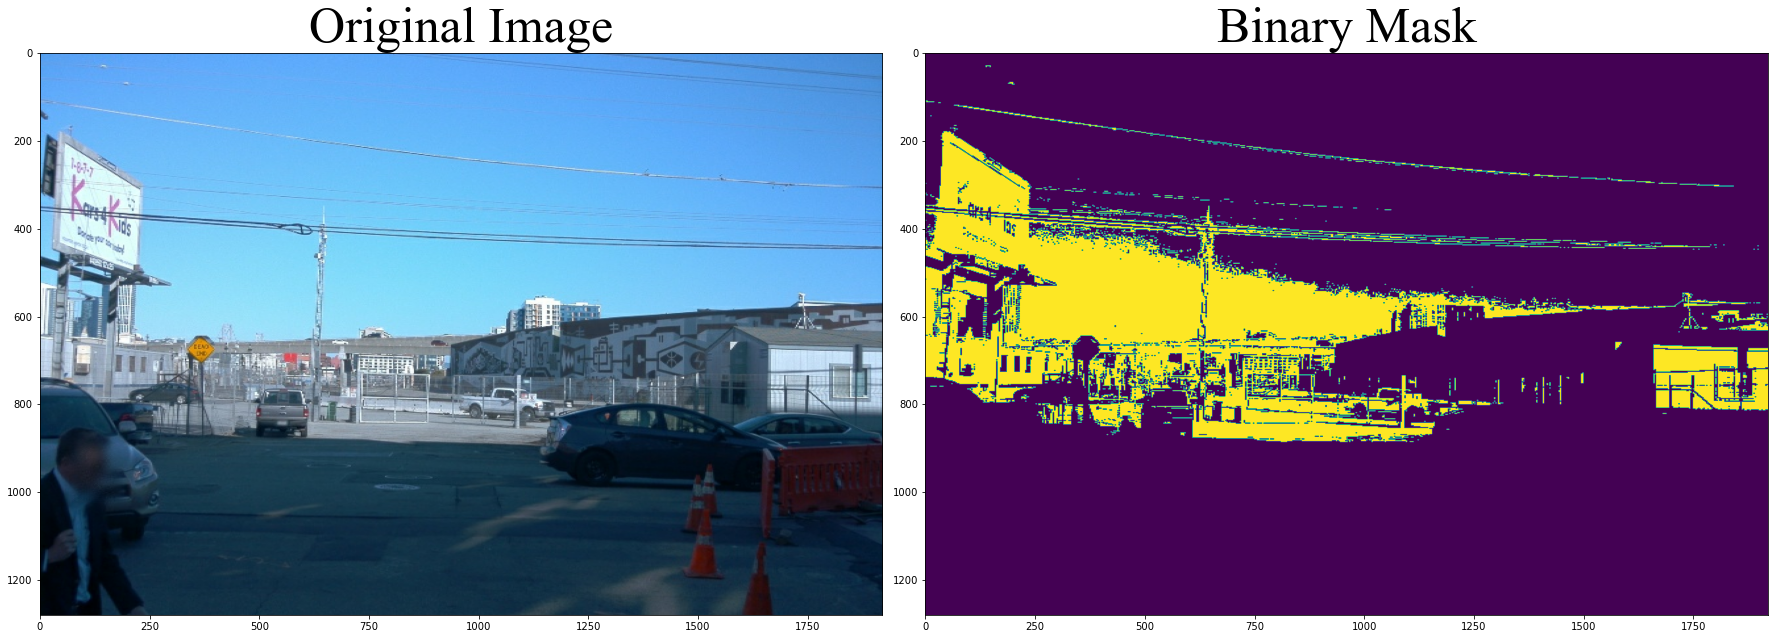

In [30]:
### Plotting the binary mask
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,9))
fig.tight_layout()
ax1.imshow(cv2.cvtColor(img_original_p1, cv2.COLOR_RGB2BGR))
ax1.set_title('Original Image', fontsize=50, fontname='Times New Roman')
ax2.imshow(binary_mask_p1)
ax2.set_title('Binary Mask', fontsize=50, fontname='Times New Roman')
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

##### Testing on Fig. 1 image

Now we will repeat the colour thresholding exercise on the image from Fig. 1. This image is unique for our problem because of it resembles a particular perception task within self-driving cars; lane line detection. Here the centre divider lane is coloured a striking yellow. We will try using colour thresholding to segment out this yellow lane line and see what kind of results we get.

In [31]:
### Loading the image path from Fig. 1
img_path = os.path.join(DIR_BASE, 'data/katie-moum-5FHv5nS7yGg-unsplash.jpg')

Recalling from [Sect. 1.1](#1.1.-Colour-Thresholding) we were able to identify the RGB colour of the centre lane line using the macOS Digital Colour Meter tool. That RGB value we identified was `(R:209, G:144, B:17)`. Let's first start with a threshold percentage of `0.0` to see how effective this colour thresholding approach is with only a single reference value to work with.

In [32]:
### Defining our colour of interest
colour_yellow = RGB(209, 144, 17)

In [33]:
# Setting the threshold amount
threshold_percent = 0.0             # value between [0,1]
rgb_lower = colour_yellow._make(colour_yellow.threshold(percent=threshold_percent, sign=-1.0))
rgb_upper = colour_yellow._make(colour_yellow.threshold(percent=threshold_percent, sign=1.0))
print('colour:     ', colour_yellow, '\nlower bound:', rgb_lower, '\nupper bound:', rgb_upper)

colour:      RGB(r=209, g=144, b=17) 
lower bound: RGB(r=209, g=144, b=17) 
upper bound: RGB(r=209, g=144, b=17)


In [34]:
### Creating the binary mask (returns a bitmap image)
img_original_f1, binary_mask_f1 = create_mask(img_path, rgb_lower, rgb_upper)

In [35]:
img_original_f1.shape, binary_mask_f1.shape

((5760, 3840, 3), (5760, 3840))

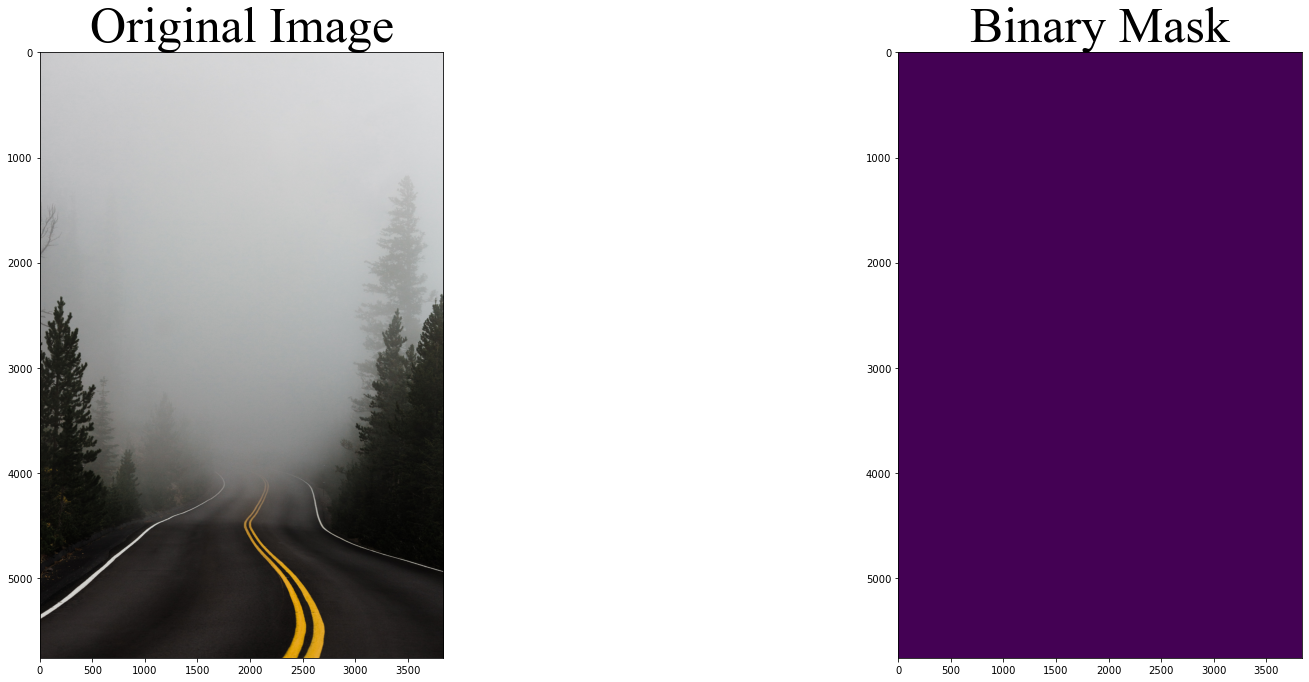

In [36]:
### Plotting the binary mask
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,9))
fig.tight_layout()
ax1.imshow(cv2.cvtColor(img_original_f1, cv2.COLOR_RGB2BGR))
ax1.set_title('Original Image', fontsize=50, fontname='Times New Roman')
ax2.imshow(binary_mask_f1)
ax2.set_title('Binary Mask', fontsize=50, fontname='Times New Roman')
#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

Unfortunately, we weren't able to obtain anything reasonable by attempting to segment only a single RGB value from our input image. While the yellow lane line might look uniform, under the hood its pixel values vary quite a bit. Let's try repeating this exercise but with an RGB threshold of something much more generous. How does _70 percent_ sound?

In [37]:
# Setting the threshold amount
threshold_percent = 0.7             # value between [0,1]
rgb_lower = colour_yellow._make(colour_yellow.threshold(percent=threshold_percent, sign=-1.0))
rgb_upper = colour_yellow._make(colour_yellow.threshold(percent=threshold_percent, sign=1.0))
print('colour:     ', colour_yellow, '\nlower bound:', rgb_lower, '\nupper bound:', rgb_upper)

colour:      RGB(r=209, g=144, b=17) 
lower bound: RGB(r=62, g=43, b=5) 
upper bound: RGB(r=255, g=244, b=28)


In [38]:
### Creating the binary mask (returns a bitmap image)
img_original_f1, binary_mask_f1_rgb = create_mask(img_path, rgb_lower, rgb_upper)

In [39]:
img_original_f1.shape, binary_mask_f1_rgb.shape

((5760, 3840, 3), (5760, 3840))

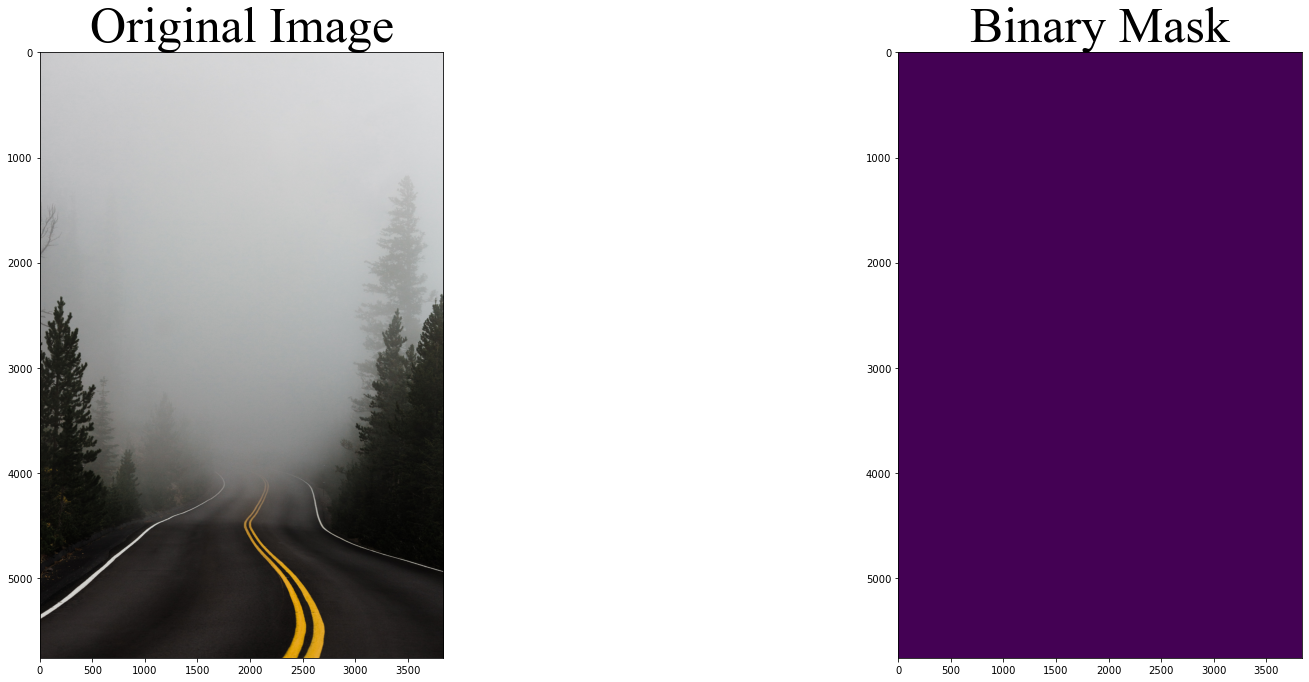

In [40]:
### Plotting the binary mask
fig,(ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,9))
fig.tight_layout()
ax1.imshow(cv2.cvtColor(img_original_f1, cv2.COLOR_RGB2BGR))
ax1.set_title('Original Image', fontsize=50, fontname='Times New Roman')
ax2.imshow(binary_mask_f1_rgb)
ax2.set_title('Binary Mask', fontsize=50, fontname='Times New Roman')
plt.show()

Even with a threshold of _70 percent_ we still aren't able to detect any yellow in the image. Crazy! 

Remember that bit on colour models in Sect. 1? Well, this here is a prime example of why we _should not_ perform colour thresholding on RGB values. Since we know that RGB is not a _linear_ colour model, we can't safely assume that changing a colour's values by a percentage in RGB will actually return us a sensible colour.

![Fig. 4. The RGB values thresholded at 70 percent, visualised with macOS ColorSync Utility.](figures/2022-08-17-Figure-4-RGB-Threshold-Bounds-70.png)

$$
\begin{align}
    \textrm{Fig. 4. The RGB colour thresholded at 70 percent, visualised with macOS ColorSync Utility.}
    \end{align}
$$

We'll be switching to the _HSV_ colour model to exploit its property of linearity. That is, when we modify the HSV _value_ attribute by a percentage, we expect to obtain a colour value closer to the intended threshold amount. By modifying the _hue_ +/- 10 degrees, we can safely select an upper and lower threshold on the colour we want. The other two parameters, _saturation_ and _value_, scale much better with a percentage in mind. According to [this](https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html) OpenCV tutorial, an ideal lower and upper bound on HSV values is `[H-10, 100, 100]` and `[H+10, 255, 255]`, respectively.

In [41]:
### Getting our colour values in HSV
colour_yellow.convert_to_hsv()

[20, 234, 209]

In [42]:
### Converting to HSV
colour_yellow_hsv = HSV._make(colour_yellow.convert_to_hsv())
colour_yellow_hsv

HSV(h=20, s=234, v=209)

In [43]:
# Setting the threshold amount
threshold_percent = 0.7             # value between [0,1]

In [44]:
hsv_lower = colour_yellow_hsv._make(colour_yellow_hsv.threshold(percent=threshold_percent, sign=-1.0))
hsv_upper = colour_yellow_hsv._make(colour_yellow_hsv.threshold(percent=threshold_percent, sign=1.0))
print('colour:     ', colour_yellow_hsv, '\nlower bound:', hsv_lower, '\nupper bound:', hsv_upper)

colour:      HSV(h=20, s=234, v=209) 
lower bound: HSV(h=6, s=70, v=62) 
upper bound: HSV(h=34, s=255, v=255)


In [45]:
### Creating the binary mask (returns a bitmap image)
img_original_f1, binary_mask_f1_hsv = create_mask(img_path, hsv_lower, hsv_upper)

In [46]:
img_original_f1.shape, binary_mask_f1_hsv.shape

((5760, 3840, 3), (5760, 3840))

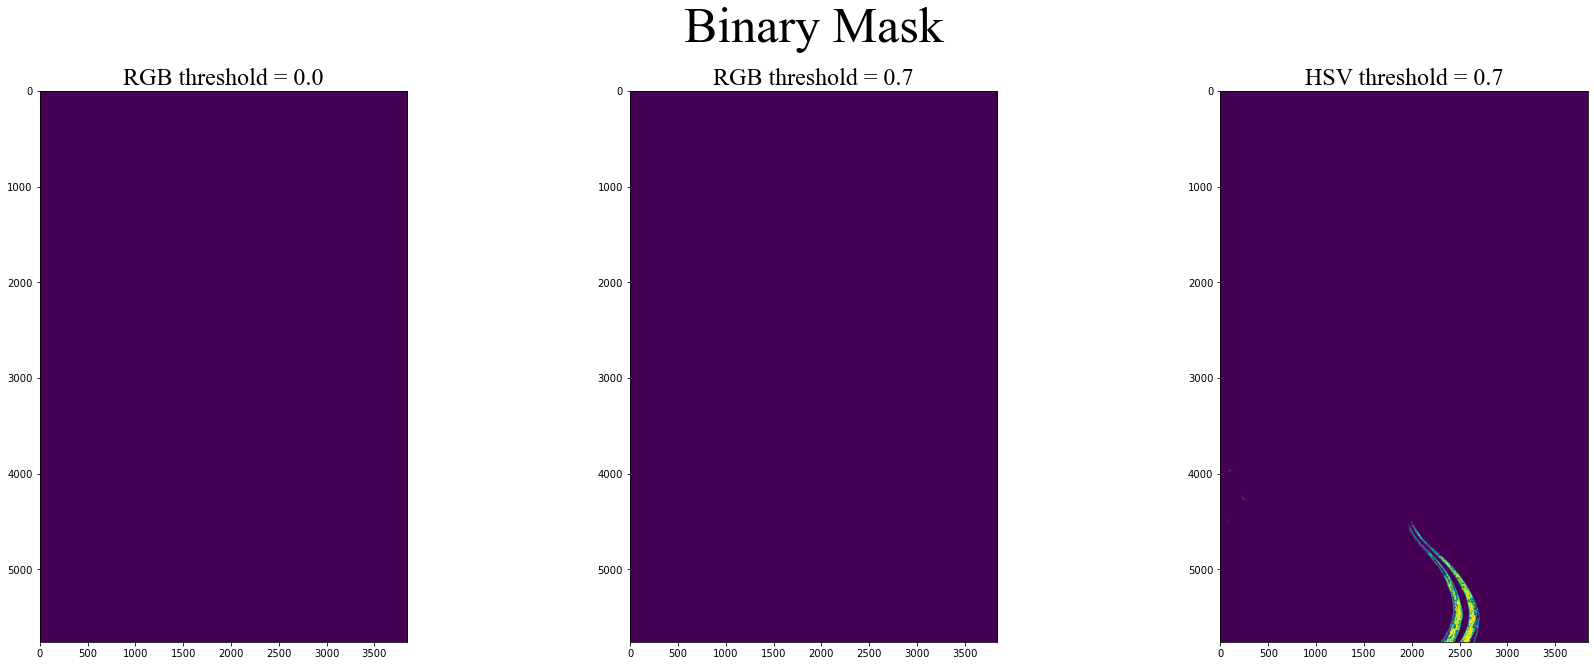

In [47]:
### Plotting the binary mask results
fig,(ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(24,9))
fig.tight_layout()
ax1.imshow(binary_mask_f1)
ax1.set_title('RGB threshold = 0.0', fontsize=24, fontname='Times New Roman')
ax2.imshow(binary_mask_f1_rgb)
ax2.set_title('RGB threshold = 0.7', fontsize=24, fontname='Times New Roman')
ax3.imshow(binary_mask_f1_hsv)
ax3.set_title('HSV threshold = 0.7', fontsize=24, fontname='Times New Roman')
fig.suptitle('Binary Mask', fontsize=50, fontname='Times New Roman')
plt.subplots_adjust(left=0., right=1, top=0.85, bottom=0.)
plt.show()

Shown on the right is our results obtained when switching to the HSV colour model thresholded with the same _70 percent_ range. Our initial yellow colour has now been properly thresholded, and as we can see in the figure, we were able to successfully segment a large portion of that centre dividing lane line based on its colour property alone.

### 2.3. Image Masking

Now that we have obtained our binary mask, we will use OpenCV's `bitwise_and()` method to clip (remove) all pixel values from our original RGB image that map to a binary mask value of '0'. In other words, in this section we are going to remove all pixels whose colour is not within the threshold we calculated previously.

#### Image masking algorithm in Python

In [48]:
def mask_and_display(img: np.ndarray, mask: np.ndarray, **display_params):
    """Masks the input image with the binary mask and displays the results."""
    
    ### Plotting the original image
    fig,(ax1, ax2, ax3) = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    fig.tight_layout()
    ax1.imshow(cv2.cvtColor(img, code=code))
    ### Plotting the binary mask
    ax2.imshow(mask)
    img_masked = cv2.bitwise_and(img, img, mask)
    ## Creating a 3-channel resulting image
    img_masked_out = img * np.stack([mask]*3, axis=2)
    ### Normalising the range of image values to apply the 
    # regular colour palette scale.
    norm = colors.Normalize(vmin=img.min(), vmax=img.max())
    ax3.imshow(img_masked, cmap=cmap, norm=norm)
    os.makedirs(DIR_OUT, exist_ok=True)
    plt.savefig(fname)
    plt.show()

In [49]:
### Matplotlib parameters
figsize = (24, 9)
nrows = 1
ncols = 3
left = 0.; right = 1; top = 0.9; bottom = 0.;
code = cv2.COLOR_RGB2BGR
# Sets the colormap for the bad (masked) values,
# the over (low) and under (high) out-of-range values
palette = copy(plt.cm.gray)
palette.set_over('r', 1.0)
palette.set_under('g', 1.0)
palette.set_bad('b', 1.0)
# Alternatively, we can make the masked region transparent
# palette.set_bad(alpha=0.0)
cmap = palette
display_params = {# Matplotlib figure parameters
                  'figsize': figsize, 'nrows': nrows, 'ncols': ncols,
                  # Matplotlib imshow and cv2.cvtColor parameters
                  'cmap': cmap, 'code': cv2.COLOR_RGB2BGR,
                  # Matplotlib subplots_adjust parameters
                  'left': left, 'right': right, 'top': top, 'bottom': bottom,
                  }

##### Testing on provided image

In [50]:
fig_id = 1                # Number to append to output filename
fname = f'{DIR_OUT}/2022-08-16-Output-{fig_id}.png'
display_params['fname'] = fname

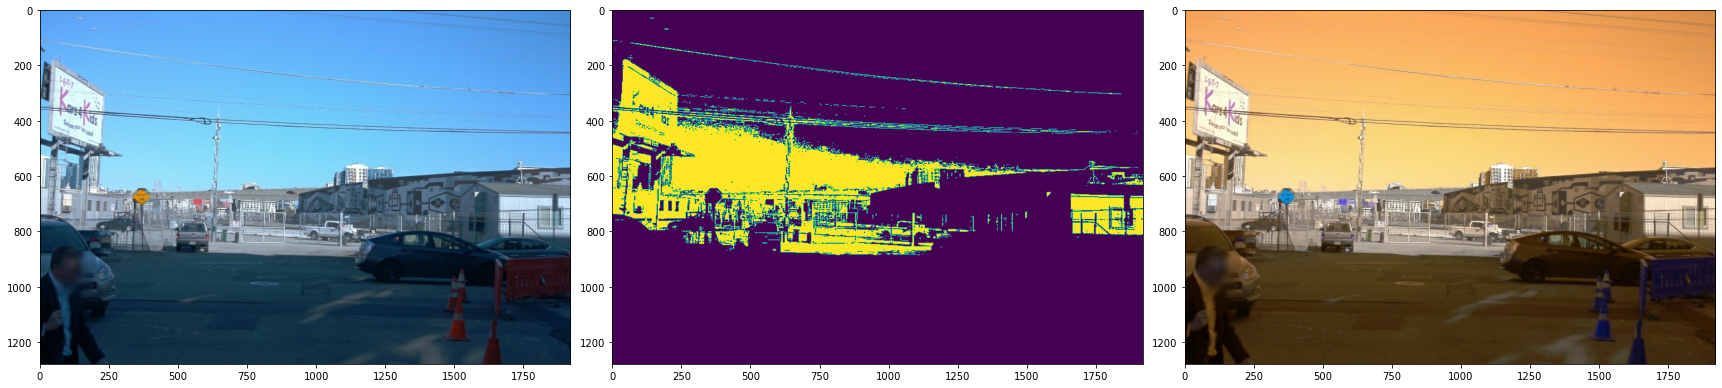

In [51]:
mask_and_display(img_original_p1, binary_mask_p1, **display_params)

Note that we are getting a somewhat unexpected result when visualising our masked image (right). Matplotlib seems to be assigning a colourmap to the image. Oddly enough, this doesn't seem to happen with the image below. I've reached out to the assignment mentors for help on this issue.

##### Testing on Fig. 1 image

In [52]:
fig_id = 2                # Number to append to output filename
fname = f'{DIR_OUT}/2022-08-16-Output-{fig_id}.png'
display_params['fname'] = fname

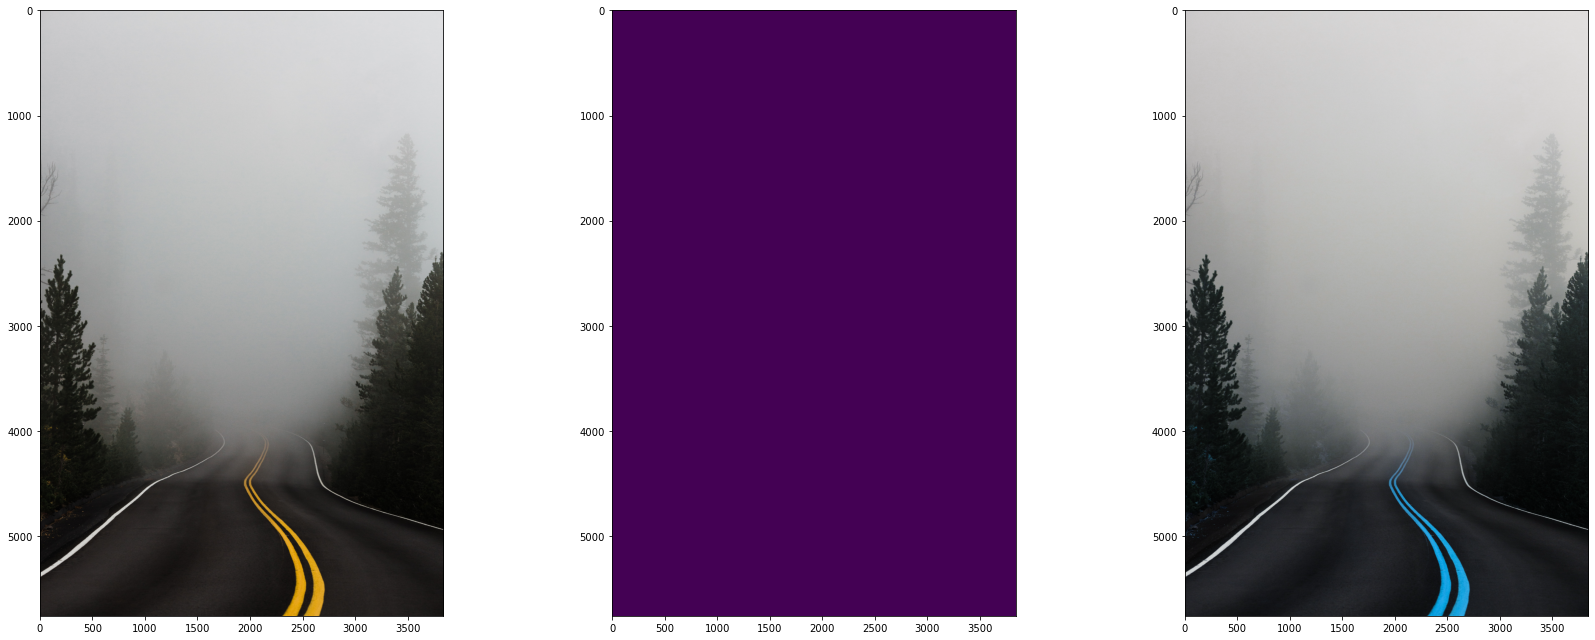

In [53]:
mask_and_display(img_original_f1, binary_mask_f1, **display_params)

Brilliant! We have a fantastic result from our test image shown on the right subplot. We can see in blue the segmented (masked) area of the image corresponding to the yellow thresholded values we defined earlier. Thanks to the HSV colour model, we also notice that our yellow values are properly accounted for even under slight lighting differences. The yellow lane line seems to be properly detected despite the presence of fog in the scene towards the horizon/vanishing point in the image.

##### Testing on Waymo Open Dataset frames

In [54]:
def batch_colour_threshold(file_paths: List[str], lower_bound: NamedTuple, upper_bound: NamedTuple=None, 
                           display=True, **params):
    """Returns a set of masked images from the input file paths.

    :param file_paths: list of absolute paths to input images (assumed to be RGB)
    :param lower_bound: a colour value, i.e., RGB, BGR or HSV NamedTuple instance
    :param upper_bound: a colour value, i.e., RGB, BGR, or HSV NamedTuple instance
    :param display: displays a Matplotlib ImageGrid with resulting masks, if True
    :param **params: ImageGrid and Matplotlib parameters.
    """
    
    masked_images = defaultdict(str)
    if save_masked:
        # Create the save directory if not exists
        os.makedirs(save_dir, exist_ok=True)
    if display:
        # Create the Matplotlib ImageGrid figure
        fig = plt.figure(figsize=figsize)
        grid = ImageGrid(fig, 111, nrows_ncols=(nrows, ncols), axes_pad=axes_pad)
        grid.axes_all[2].set_title(label=label, fontname=fontname)
    for i, img_path in enumerate(file_paths):
        # Get file name
        img_fname = os.path.basename(img_path)
        try:
            # Creating a mask from image and threshold bounds 
            img, mask = create_mask(img_path, lower_bound, upper_bound)
        except Exception as ex:
            # Log image filename with incorrect colour format
            logging.exception(str(e) + f'{img_fname}')
            # Skip the image if not colour
            continue
        # Create the 3-channel masked image
        # img_masked = cv2.bitwise_and(img, img, mask)
        img_masked = img * np.stack([mask]*3, axis=2)
        # Store masked image array in dict entry
        masked_images[img_fname] = img_masked
        if save_masked: 
            # Write masked image to `.png` file
            img_fp_out = os.path.join(save_dir, f'{img_fname}_masked-{str(i+1).zfill(4)}.png')
            cv2.imwrite(img_fp_out, img_masked)
        if display:
            try:
                grid[i].imshow(img_masked)
                grid[i].axis('off')
            except IndexError as e:        
                logging.exception(str(e) + f'_{img_fname}')
    if display:
        plt.show()
    return masked_images

In [55]:
DIR_SRC = os.path.join(DIR_BASE, 'data/images')

In [56]:
file_paths_waymo = glob.glob(f'{DIR_SRC}//*.png')

In [57]:
target_colour = RGB(200, 200, 200)

In [58]:
### Hand-crafting RGB range to threshold (looking for white lane lines)
rgb_lower = RGB._make([180,180,180])
rgb_upper = RGB._make([255,255,255])
print('colour:     ', target_colour, '\nlower bound:', rgb_lower, '\nupper bound:', rgb_upper)

colour:      RGB(r=200, g=200, b=200) 
lower bound: RGB(r=180, g=180, b=180) 
upper bound: RGB(r=255, g=255, b=255)


In [59]:
# Function parameters
save_masked = False             # Saves masked images if True
save_dir = os.path.join(DIR_BASE, 'out/images_masked')

# ImageGrid parameters
figsize = (24,24)
ncols = 5
nrows = len(file_paths_waymo) // ncols
axes_pad = 0.2
fontname = 'Times New Roman'
label = 'Image masks using colour thresholding'
grid_params = {'figsize': figsize, 'ncols': ncols, 'nrows': nrows, 'axes_pad': axes_pad}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

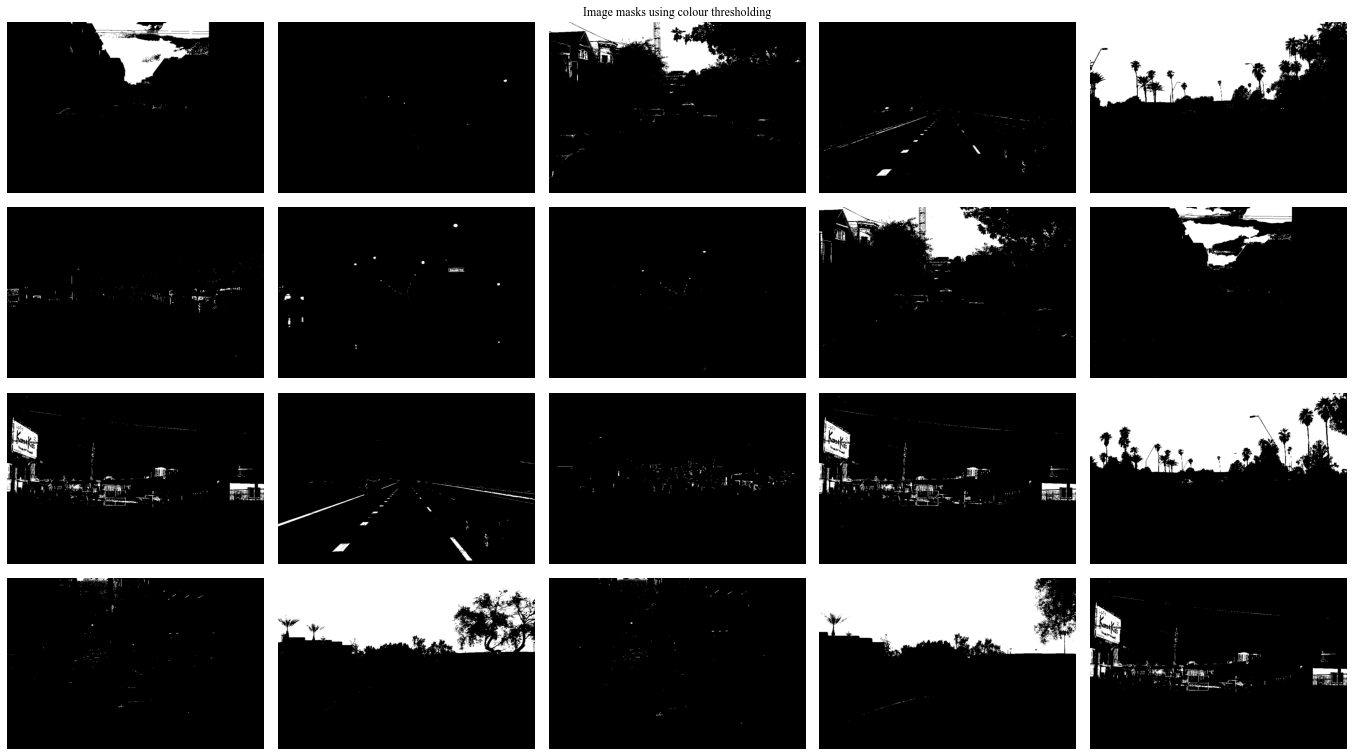

In [60]:
masked_images = batch_colour_threshold(file_paths_waymo, rgb_lower, rgb_upper, grid_params)

### 2.4. Pixel Value Statistics

#### Computing image statistics in Python

The `calculate_mean_std` function outputs the channel wise mean and standard deviation over a list in images. This function outputs two `1x3` Numpy array, one for the mean and one for the standard deviation.

In [61]:
### From Udacity's `statistics.py`

In [62]:
def calculate_mean_std(image_paths: List[str], squared: bool=False) -> (np.ndarray, np.ndarray):
    """Returns the dataset mean and standard deviation.
    
    Each image statistic is averaged across per-channel values.
    The mean values are calculated for all images in the dataset.
    
    :param image_paths: list of image file paths
    :param squared: boolean flag indicating whether or not to
        compute the squared sum of all pixel values
    :returns: mean, 1x3 array of channel-wise mean average values,
              std_dev, 1x3 array of channel-wise standard deviations.
    """
    
    means = []
    std_devs = []
    for i, img_path in enumerate(image_paths):
        # Read in the image and convert to RGB if needed
        img = Image.open(img_path).convert('RGB')
        # Obtain the image dimensions
        w, h = img.width, img.height
        n_pixels = w * h
        # Compute the image stats
        img_stats = ImageStat.Stat(img)
        # Get the standard deviation
        std_devs.append(np.array(img_stats.stddev))
        if squared:
            # Get the squared sum of all pixels per-channel
            ssum = np.array(img_stats.sum2)
            # Compute the mean and take the square root
            mean = ssum / n_pixels
            means.append(np.sqrt(mean))
        else:
            means.append(np.array(img_stats.mean))
    # Compute the dataset mean average value and average standard deviation
    mean = np.mean(means, axis=0)
    std_dev = np.mean(std_devs, axis=0)
    return mean, std_dev

In [63]:
img_path = os.path.join(DIR_BASE, 'data/images/')

In [64]:
img_file_paths = glob.glob(f'{img_path}/*.png')

##### Calculating the per-channel image statistics

In [65]:
mean, std_dev = calculate_mean_std(img_file_paths, squared=True)
print('mean:    (R: {:.4f}, G: {:.4f}, B: {:.4f})'.format(mean[0], mean[1], mean[2]))
print('std dev: (R:  {:.4f}, G:  {:.4f}, B:  {:.4f})'.format(std_dev[0], std_dev[1], std_dev[2]))

mean:    (R: 106.9101, G: 122.6201, B: 137.7230)
std dev: (R:  47.0261, G:  52.3179, B:  59.4787)


The `channel_histogram` function creates the channel wise histograms. You should encode each distribution with the same colour channel as shown in the example above.

In [66]:
### From Udacity's `statistics.py`

In [67]:
def channel_histogram(image_paths: List[str]):
    """Returns the 1D colour histogram.
    
    Plots the channel-wise distribution of pixel values.
    
    :param image_paths: list of image paths.
    """

    # Lists to store dataset channel values
    red = []; green = []; blue = []
    for img_path in image_paths:
        # Read in image data and convert to RGB if needed
        img = np.array(Image.open(img_path).convert('RGB'))
        # Get the individual channels
        R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]
        # Add image channel data to lists
        red.extend(R.flatten().tolist())
        green.extend(G.flatten().tolist())
        blue.extend(B.flatten().tolist())
    # Plot the histogram (kernel density estimate) plot using Seaborn
    plt.figure(figsize=(24,20))
    sns.kdeplot(red, color='r')
    sns.kdeplot(green, color='g')
    sns.kdeplot(blue, color='b')

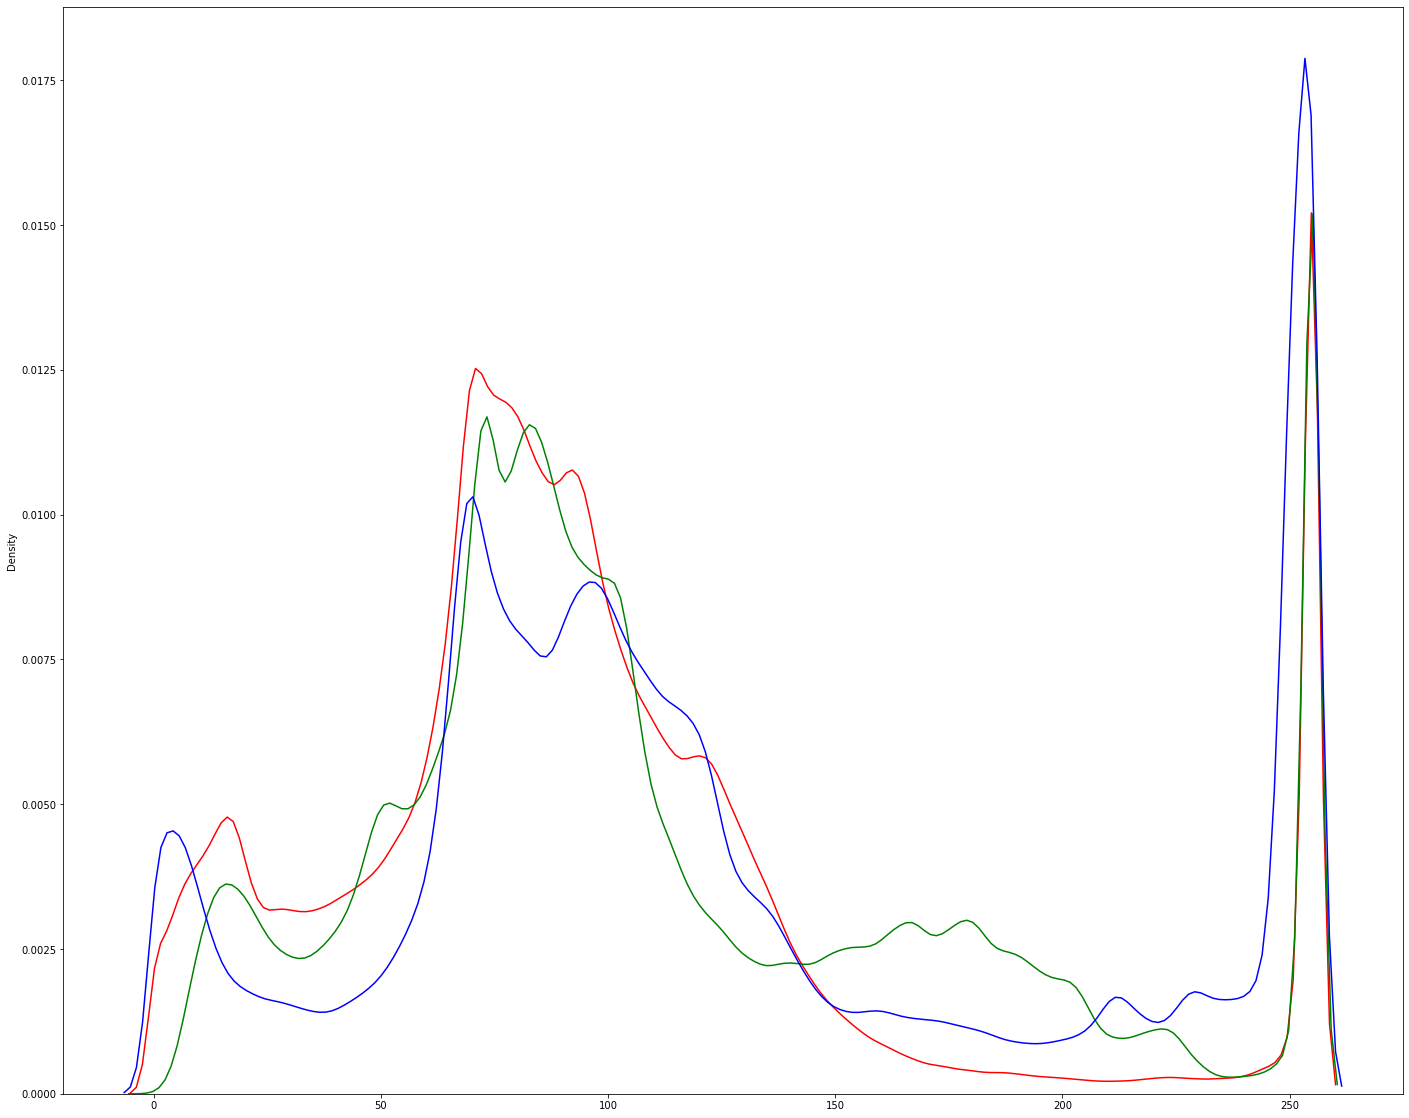

In [68]:
### Plotting the 'flattened' 1D colour histogram
channel_histogram(img_file_paths)

Great, we now have a 1D histogram representing the individual colour channel distributions. On the x-axis, we have a range of values [0, 255] corresponding to our pixel intensity values. On the y-axis we have the corresponding density function, which put more simply, is a function of pixel counts in each bin (here, we have 256 bins, one of each pixel).

_So what does this histogram tell us?_
We see a substantial peak in all three channels R, G, B around bin number 250. This likely corresponds to the amount of 'white' pixels present in our dataset. We also see a peak around the 90th bin in all three channels. Looking up the corresponding RGB colour `(90, 90, 90)`, we see that it likely represents the amount of dark grey present on the road surfaces in our images.

##### Evaluating Task Three output

In [69]:
### From Udacity's `utils.py`

In [70]:
def check_results(mean, std):
    # calculate L1 distance
    gt_mean = np.array([ 95.30968145, 110.46818685, 123.70005162])
    mean_dst = np.sum(np.abs(np.array(mean) - gt_mean))
    assert mean_dst < 0.0001, 'The mean calculation is incorrect.'

    gt_std = np.array([47.02613582, 52.31789603, 59.47874234])
    std_dst = np.sum(np.abs(np.array(std) - gt_std))
    assert std_dst < 0.0001, 'The std calculation is incorrect.'
    print('Congrats, all calculations are correct!')

In [71]:
### Comparing our results to Udacity's
mean, std_dev = calculate_mean_std(img_file_paths, squared=False)
check_results(mean, std_dev)

Congrats, all calculations are correct!


## 3. Closing Remarks
##### Alternatives
* Consider alternative colour spaces for e.g., compression (YCbCr) or human reproducibility (YUV)
* Compute multi-dimensional colour histograms

##### Extensions of task
* Use image gradients to find regions of interest with e.g., Canny edge detection;
* Project features from image space $x$-$y$ onto feature space $m$-$b$ with e.g., Hough transform to map line intersections;
   * Note: polar coordinates (rho, theta) are the perpendicular distance, angle of line from horizontal, reprojection of image points into Hough space form sine curves whose intersections represent lane lines.

## 4. Future Work
- ⬜️ Create a simple function to display RGB/BGR/HSV colour.

## Credits
This assignment was prepared by Cezanne Camacho, Sudhanshu Kulshrestha and Michael Virgo et al., Winter 2021 (link [here]()).

References:
* [1] Joblove, G. et al. Color Spaces for Computer Graphics, ACM SIGGRAPH Computer Graphics, 12(3):20-25, 1978. [doi:10.1145/965139.807362](https://doi.org/10.1145/965139.807362).

Helpful resources:
* [Color spaces | OpenCV](https://docs.opencv.org/4.x/df/d9d/tutorial_py_colorspaces.html)
* [Finding Lane Lines with Colour Thresholds by J. Owoyemi | Medium](https://tjosh.medium.com/finding-lane-lines-with-colour-thresholds-beb542e0d839)
* [Computer Vision Fundamentals — Self-Driving Cars (Finding Lane Lines) | Medium](https://medium.com/geekculture/computer-vision-fundamentals-self-driving-cars-finding-lane-lines-4bbae0c6df0d)
* [Averaging RGB Colors the Right Way by M. Vanga](https://sighack.com/post/averaging-rgb-colors-the-right-way)
* [Guide to Utilizing Color Histograms for Computer Vision and Image Search Engines | Pyimagesearch](https://pyimagesearch.com/2014/01/22/clever-girl-a-guide-to-utilizing-color-histograms-for-computer-vision-and-image-search-engines/)